In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [81]:
train_data = pd.read_csv('train.csv')

## Trimming dataset

In [82]:
train_data = train_data.dropna()
subset_size = 1_000
train_data = train_data.sample(n=subset_size)

## Filling na, scaling, making defining categorical columns, text preprocessing, split data

In [83]:
numeric_cols = ['price']
categorical_cols = ['region', 'city', 'parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3',
                    'user_type', 'image_top_1']

label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    train_data[col] = label_encoders[col].fit_transform(train_data[col].astype(str))


scaler = StandardScaler()
train_data[numeric_cols] = scaler.fit_transform(train_data[numeric_cols])

text_cols = ['title', 'description']
tfidf = TfidfVectorizer(max_features=1000)
text_features = tfidf.fit_transform(train_data[text_cols].apply(lambda x: ' '.join(x), axis=1))
text_features_df = pd.DataFrame(text_features.toarray(), index=train_data.index)


X = pd.concat([train_data[numeric_cols + categorical_cols], text_features_df], axis=1)
y = train_data['deal_probability']

X.columns = X.columns.astype(str)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Setting parameters for models

In [99]:
param_grid_knn = {
    'n_neighbors': [5, 10, 20],
    'weights': ['uniform', 'distance']
}

param_grid_linear = {
    'fit_intercept': [True, False]
}

param_grid_lasso = {
    'alpha': [0.1, 1.0, 10.0],
    'max_iter': [1000, 5000, 10000]
}

param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0]
}

param_grid_nn = {
    'hidden_layer_sizes': [(100,), (200,), (100, 100), (200, 200), (100, 100, 100), (200, 200, 200)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd']
}

## Selecting models to train

In [100]:
models = [
    ('Constant', None, None),
    ('KNN', KNeighborsRegressor(), param_grid_knn),
    ('Linear', LinearRegression(), param_grid_linear),
    ('Lasso', Lasso(), param_grid_lasso),
    ('Ridge', Ridge(), param_grid_ridge),
    ('Neural Network', MLPRegressor(), param_grid_nn)
]

## Training models

In [101]:
results = []
for model_name, model, param_grid in models:
    if model is None:
        y_pred_test = np.full_like(y_test, y_train.mean())
        cv_score = -1 * np.sqrt(np.mean((y_train - y_train.mean()) ** 2))
    else:
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred_test = best_model.predict(X_test)
        cv_score = -1 * grid_search.best_score_

    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    results.append((model_name, cv_score, test_rmse))

C:\Users\Corsair\Desktop\4803\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Corsair\Desktop\4803\venv\Lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\Corsair\Desktop\4803\venv\Lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\Corsair\Desktop\4803\venv\Lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\Corsair\Desktop\4803\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Corsair\Desktop\4803\venv\Lib\site-packages\sklearn\neural_network\_ba

## CV Score and RMSE

In [102]:
print("{:<20} {:<20} {:<20}".format("Model", "CV Score", "Test RMSE"))
print("-" * 60)
for model_name, cv_score, test_rmse in results:
    print("{:<20} {:<20.4f} {:<20.4f}".format(model_name, cv_score, test_rmse))

Model                CV Score             Test RMSE           
------------------------------------------------------------
Constant             -0.2156              0.2056              
KNN                  0.2153               0.1948              
Linear               1.5335               21.1043             
Lasso                0.2111               0.2023              
Ridge                0.2015               0.1916              
Neural Network       0.2195               0.2098              


## Test RMSE Comparison

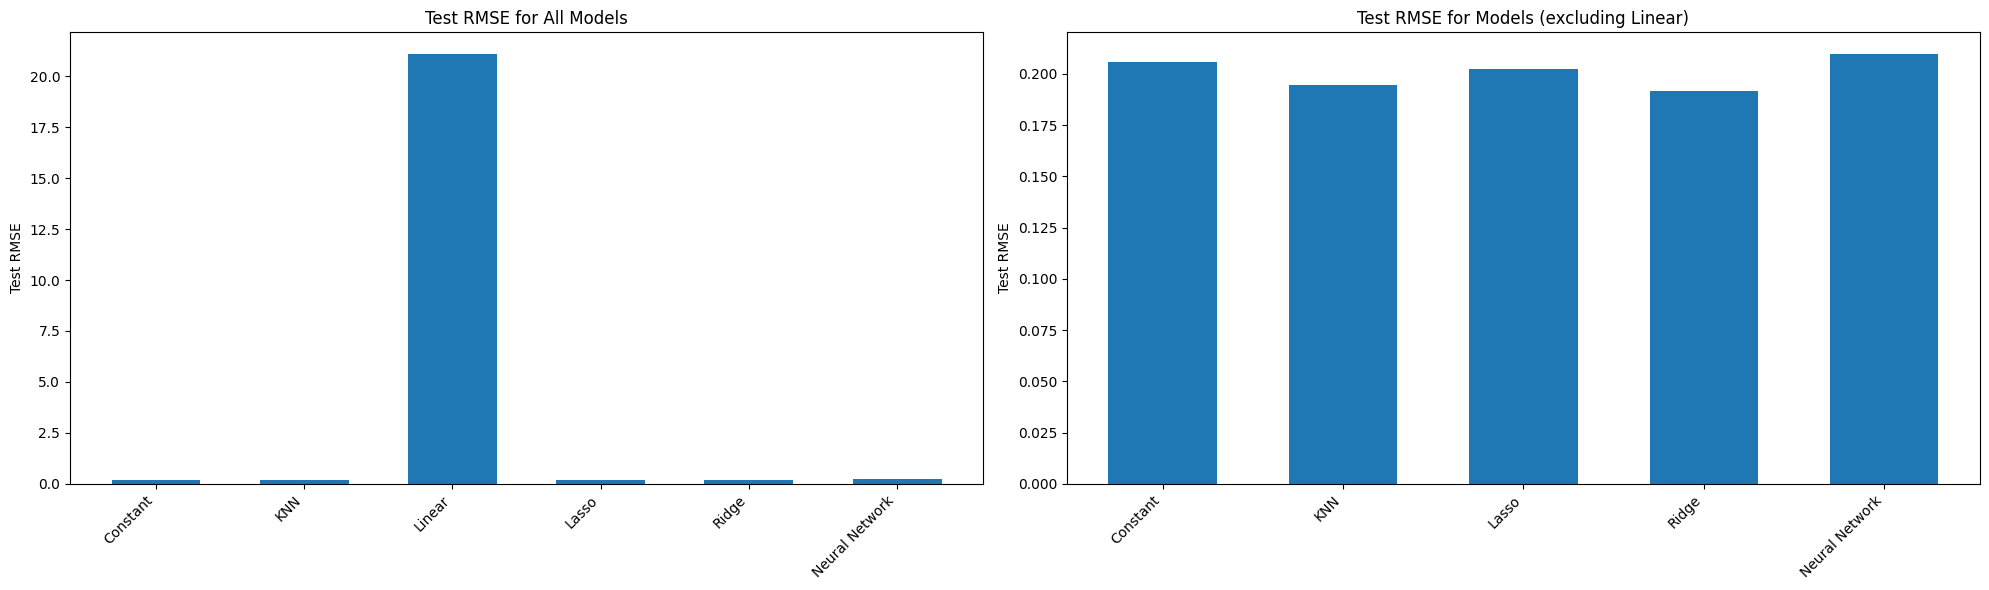

In [103]:
models_names = [result[0] for result in results]
test_rmse = [result[2] for result in results]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
x = np.arange(len(models_names))

ax1.bar(x, test_rmse, width=0.6)
ax1.set_ylabel('Test RMSE')
ax1.set_title('Test RMSE for All Models')
ax1.set_xticks(x)
ax1.set_xticklabels(models_names, rotation=45, ha='right')

models_without_linear = [m for m in models if m[0] != 'Linear']
models_names_without_linear = [m[0] for m in models_without_linear]
test_rmse_without_linear = [r[2] for r in results if r[0] != 'Linear']

x_without_linear = np.arange(len(models_names_without_linear))
ax2.bar(x_without_linear, test_rmse_without_linear, width=0.6)
ax2.set_ylabel('Test RMSE')
ax2.set_title('Test RMSE for Models (excluding Linear)')
ax2.set_xticks(x_without_linear)
ax2.set_xticklabels(models_names_without_linear, rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Resizing and exporting plot 2

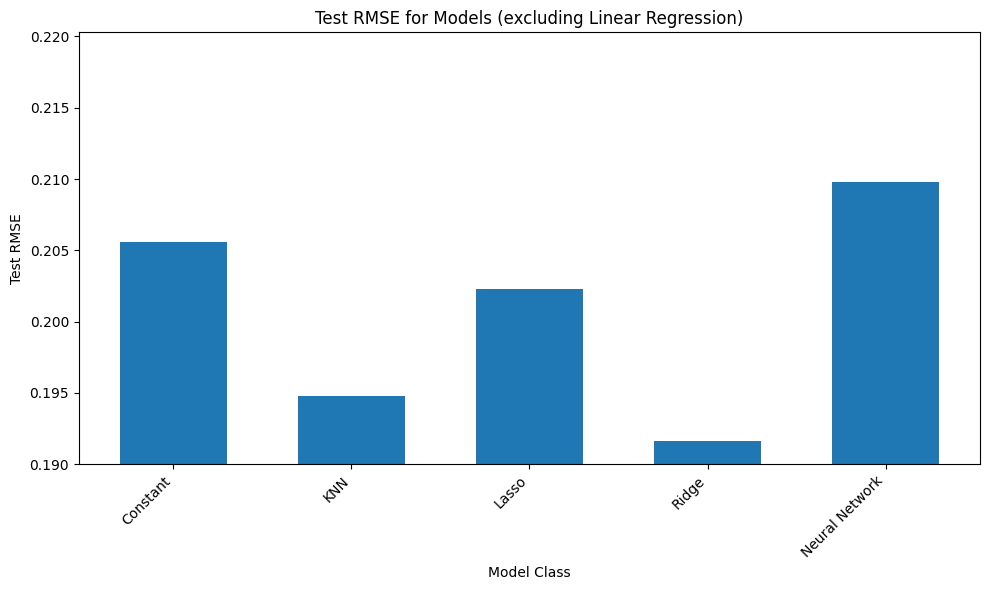

In [113]:
model_names = ['Constant', 'KNN', 'Lasso', 'Ridge', 'Neural Network']
test_rmse = [0.2056, 0.1948, 0.2023, 0.1916, 0.2098]

fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(model_names))
ax.bar(x, test_rmse, width=0.6)
ax.set_xlabel('Model Class')
ax.set_ylabel('Test RMSE')
ax.set_title('Test RMSE for Models (excluding Linear Regression)')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')

ax.set_ylim(bottom=0.19)

plt.tight_layout()
plt.savefig('test_rmse_plot_no_linear.png')
plt.show()

### Exporting the subset of the training data used for the analysis

In [114]:
train_data.to_csv('sampled_train_data.csv', index=False)